# Denoising Autoencoder

In [1]:
import torch
import numpy as np
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# how many samples per batch to load
batch_size = 20

# how many subprocesses to use for data loading
num_workers = 1

# prepare data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

Using downloaded and verified file: data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw
Using downloaded and verified file: data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw
Using downloaded and verified file: data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw
Using downloaded and verified file: data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


### Visualize the Data

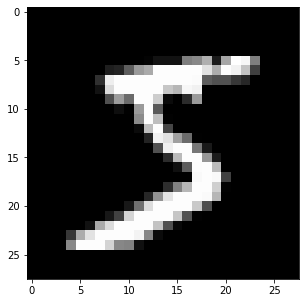

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

### Adding noise

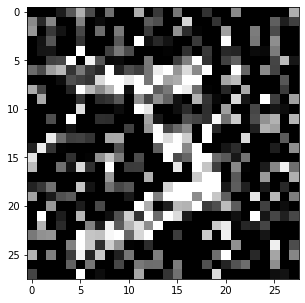

In [5]:
# for adding noise to images
noise_factor=0.5

# add random noise to the input images
noisy_img = img + noise_factor * np.random.randn(*img.shape)

# clip the images to be between 0 and 1
noisy_img = np.clip(noisy_img, 0., 1.)

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(noisy_img, cmap='gray')

---
# Denoising

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        
        ###########
        # Encoder #
        ###########
        
        # conv layer (depth from 1 --> 32), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)\
        
        # conv layer (depth from 32 --> 16), 3x3 kernels
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        
        
        ###########
        # Decoder #
        ###########
        
        # transpose layer, a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  # kernel_size=3 to get to a 7x7 image output
        
        # two more transpose layers with a kernel of 2
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        
        # one final normal conv layer to decrease the depth
        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)
        
        
        
        self.to(device)


    def forward(self, x):
        
        ############
        # Encoding #
        ############
        
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        # add second hidden layer + pooling
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        # add third hidden layer + pooling
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # compressed representation
        
        
        
        ############
        # Decoding #
        ############
        
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        
        # transpose again. Output should have a sigmoid applied
        x = torch.sigmoid(self.conv_out(x))
        
        
                
        return x

# initialize the NN
model = ConvDenoiser()

print(model)

ConvDenoiser(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


---
## Training

In [7]:
# specify loss function
criterion = nn.MSELoss()

# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
# number of epochs to train the model
n_epochs = 200

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    
    for data in train_loader:
        images, _ = data
        
        # add random noise to the input images
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        
        # clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
                
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs.to(device))
        
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images.to(device))
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 1 	Training Loss: 0.947280
Epoch: 2 	Training Loss: 0.571630
Epoch: 3 	Training Loss: 0.512487
Epoch: 4 	Training Loss: 0.486350
Epoch: 5 	Training Loss: 0.470357
Epoch: 6 	Training Loss: 0.460028
Epoch: 7 	Training Loss: 0.452405
Epoch: 8 	Training Loss: 0.445431
Epoch: 9 	Training Loss: 0.440427
Epoch: 10 	Training Loss: 0.434018
Epoch: 11 	Training Loss: 0.428891
Epoch: 12 	Training Loss: 0.424503
Epoch: 13 	Training Loss: 0.421113
Epoch: 14 	Training Loss: 0.416667
Epoch: 15 	Training Loss: 0.412977
Epoch: 16 	Training Loss: 0.409181
Epoch: 17 	Training Loss: 0.405516
Epoch: 18 	Training Loss: 0.400078
Epoch: 19 	Training Loss: 0.392771
Epoch: 20 	Training Loss: 0.385897
Epoch: 21 	Training Loss: 0.382228
Epoch: 22 	Training Loss: 0.378411
Epoch: 23 	Training Loss: 0.375897
Epoch: 24 	Training Loss: 0.373178
Epoch: 25 	Training Loss: 0.371317
Epoch: 26 	Training Loss: 0.369027
Epoch: 27 	Training Loss: 0.367820
Epoch: 28 	Training Loss: 0.365660
Epoch: 29 	Training Loss: 0.3

## Checking out the results

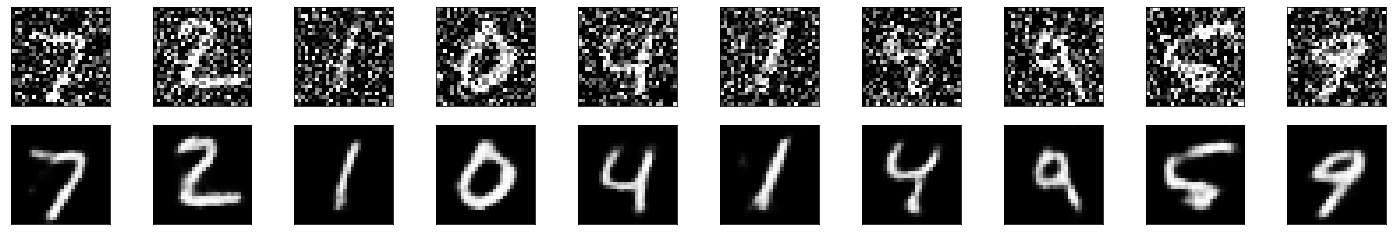

In [9]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
output = model(noisy_imgs.to(device))

# prep images for display
noisy_imgs = noisy_imgs.cpu().numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)

# use detach when it's an output that requires_grad
output = output.detach().cpu().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)